In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings("ignore")

In [130]:
import json
import glob
from tqdm.notebook import trange, tqdm
import numpy as np
import pandas as pd
from features import prepare_entry, get_transformer, merge_entries
from utills import chunker, compress_fraction
import pickle
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.style as style
from pushshift_api import get_user_comments
from datetime import datetime
%matplotlib inline

import networkx as nx
from plotly.offline import init_notebook_mode
import plotly.offline as py
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [3]:
from config import known_bots

In [4]:
tqdm.pandas()

In [5]:
DATA_DIR = '../data/'
TEMP_DIR = '../temp_data/'
DATA_PATH = DATA_DIR + 'gamestop/comments.jsonl'
TEMP_DATA_PATH = TEMP_DIR + 'sockpuppets/gamestop/'
MULTIDOC_MODEL_PATH = TEMP_DIR + 'reddit/multidoc_20/model_20.p'
SINGLEDOC_MODEL_PATH = TEMP_DIR + 'reddit/unchunked/model.p'
chunk_sz = 20

In [35]:
def preprocess(comments, chunk_sz):
    return [prepare_entry('\n'.join(c), mode='accurate', tokenizer='casual') for c in chunker(comments, chunk_sz)]

Load & Filter Data
===

In [116]:
with open(DATA_PATH, 'r') as f:
    data = []
    for l in f:
        data.append(json.loads(l))

In [117]:
df = pd.DataFrame.from_dict(data)

# Select comments from users who has at least 100 comments and remove known bots
author_comment_counts = df.groupby('author').count()['body'].to_frame()
author_comment_counts.columns = ['count']
selected_authors = author_comment_counts.loc[author_comment_counts['count'] > 100].index.values
selected_authors = set(np.setdiff1d(selected_authors, known_bots))
df = df.loc[[r['author'] in selected_authors for i, r in df.iterrows()]]

# Collect each author's comments in a list
author_comments = df.groupby('author')['body'].apply(list)

In [118]:
author_comments = author_comments.to_frame()

In [24]:
author_comments['compress_fraction'] = author_comments['body'].progress_apply(lambda comments: compress_fraction('\n'.join(comments)))

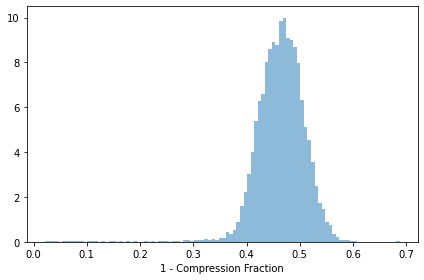

In [26]:
fig, ax = plt.subplots()

ax.hist(author_comments['compress_fraction'], bins=100, alpha=0.5, density=True)

ax.set_xlabel('1 - Compression Fraction')

plt.tight_layout()
plt.show()

In [33]:
author_comments_filtered = author_comments.loc[author_comments['compress_fraction'] < 0.3]

In [195]:
with open(TEMP_DATA_PATH + 'vectorizing_parameters.p', 'rb') as f:
    selected_authors, total_chunks, author_bounds, author_to_idx_nc, x_shape, x_shape_nc = pickle.load(f)

In [196]:
len(selected_authors)

7318

Load Predictions From HPC
===

In [153]:
result_files = [TEMP_DATA_PATH + 'predict_results_instance_' + str(i) + '.p' for i in range(20)]

In [154]:
user_pairs = []
probs_nc = []

inter_probs_mean = []
inter_probs_std = []

intraA_probs_mean = []
intraA_probs_std = []

intraB_probs_mean = []
intraB_probs_std = []
pred_lengths = []
    
for fp in tqdm(result_files):
    with open(fp, 'rb') as f:
        try:
            (
                local_probs_nc,
                local_inter_probs_mean,
                local_inter_probs_std,
                local_intraA_probs_mean,
                local_intraA_probs_std,
                local_intraB_probs_mean,
                local_intraB_probs_std,
                local_pred_lengths,
                _, 
                local_user_pairs
            ) = pickle.load(f)
            
            probs_nc.extend(local_probs_nc)
            inter_probs_mean.extend(local_inter_probs_mean)
            inter_probs_std.extend(local_inter_probs_std)
            intraA_probs_mean.extend(local_intraA_probs_mean)
            intraA_probs_std.extend(local_intraA_probs_std)
            intraB_probs_mean.extend(local_intraB_probs_mean)
            intraB_probs_std.extend(local_intraB_probs_std)
            pred_lengths.extend(local_pred_lengths)
            user_pairs.extend(local_user_pairs)
        except:
            continue

In [155]:
user_pairs = np.array(user_pairs)

In [156]:
len(user_pairs)

26763255

In [157]:
inter_probs_mean = np.array(inter_probs_mean)
intraA_probs_mean = np.array(intraA_probs_mean)
intraB_probs_mean = np.array(intraB_probs_mean)
inter_probs_std = np.array(inter_probs_std)
intraA_probs_std = np.array(intraA_probs_std)
intraB_probs_std = np.array(intraB_probs_std)
pred_lengths = np.array(pred_lengths)


probs_nc = np.array(probs_nc)

n_a = pred_lengths[:, 0]
n_b = pred_lengths[:, 1]
n_ab = pred_lengths[:, 2]

intra_probs_mean = (intraA_probs_mean * n_a + intraB_probs_mean * n_b)/ (n_a + n_b)
intra_probs_std = (
        n_a * (intraA_probs_std ** 2 + (intraA_probs_mean - intra_probs_mean)**2) + 
        n_b * (intraB_probs_std ** 2 + (intraB_probs_mean - intra_probs_mean)**2)
    ) / (n_a + n_b)


pooled_mean = (intra_probs_mean * (n_a + n_b) + inter_probs_mean * n_ab)/ (n_a + n_b + n_ab)
pooled_std = (
        (n_a + n_b) * (intra_probs_mean ** 2 + (intra_probs_mean - pooled_mean)**2) + 
        n_ab * (inter_probs_mean ** 2 + (inter_probs_mean - pooled_mean)**2)
    ) / (n_a + n_b + n_ab)


In [158]:
inter_intra_sim = (1 - np.abs(inter_probs_mean - intra_probs_mean))
aggr_score = (probs_nc * (1 - np.abs(inter_probs_mean - intra_probs_mean)))

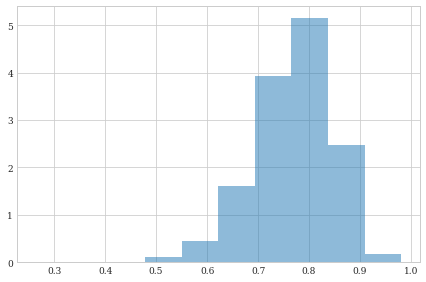

In [159]:
fig, ax = plt.subplots()

ax.hist(intra_probs_mean, alpha=0.5, density=True)


plt.tight_layout()
plt.show()

In [253]:
FIGURES_PATH = '../figures/'
TEXT_WIDTH = 7.0 # Text with on a column
HALF_COL_WIDTH = (TEXT_WIDTH - 0.5)/2
HEIGHT = 2


style.use('seaborn-whitegrid')

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = [ 'Times New Roman', 'Times', 'DejaVu Serif',
 'Bitstream Vera Serif',
 'Computer Modern Roman',
 'New Century Schoolbook',
 'Century Schoolbook L',
 'Utopia',
 'ITC Bookman',
 'Bookman',
 'Nimbus Roman No9 L',
 'Palatino',
 'Charter',
 'serif']
rcParams['font.size']=9 

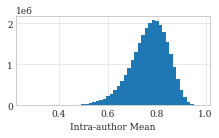

In [254]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))

plt.hist(intra_probs_mean, bins=50)

plt.xlabel('Intra-author Mean')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()
fig.savefig(FIGURES_PATH + 'plt_gamestop_intra_author_mean.pdf', bbox_inches='tight')

In [161]:
intra_probs_mean.mean()

0.768961157608965

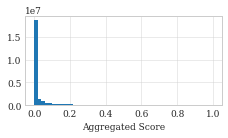

In [255]:
fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))

plt.hist(aggr_score, bins=50)

plt.xlabel('Aggregated Score')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()
fig.savefig(FIGURES_PATH + 'plt_gamestop_aggre_score.pdf', bbox_inches='tight')

In [243]:
selected_mask = aggr_score > 0.995

In [244]:
G = nx.Graph()
G.add_weighted_edges_from([
    (user_pairs[i][0], user_pairs[i][1], aggr_score[i]) 
    for i in np.argwhere(selected_mask)[:, 0]
])

nx.write_gexf(G, 'gamestop_new.gexf')

Check if suspended
===

In [55]:
import praw

reddit = praw.Reddit(client_id="XX",
                     client_secret="XX",
                     user_agent="my user agent")

In [247]:
# account_status = {}
for n in tqdm(G.nodes):
    if n in account_status:
        continue
    status = 'live'
    u = reddit.redditor(n)
    try:
        if hasattr(u, 'is_suspended'):
            status='suspended'
    except Exception as ex:
        if 'NotFound' in str(type(ex)):
            status='deleted'
        else:
            break
    account_status[n] = status

In [236]:
with open(TEMP_DATA_PATH + 'account_status.p', 'wb') as f:
    pickle.dump(account_status, f)

In [235]:
status_to_polygon = {
    'live': 0,
    'suspended': 3,
    'deleted': 4
}

In [249]:
for n in G.nodes:
    G.node[n]['account_status'] = account_status[n]
    G.node[n]['Polygon_string'] = status_to_polygon[account_status[n]]
    
# nx.write_gexf(G, 'gamestop.gexf')    

In [250]:
print('Suspended:', len([n for n in G.nodes if G.nodes[n]['account_status'] == 'suspended']))
print('Deleted:', len([n for n in G.nodes if G.nodes[n]['account_status'] == 'deleted']))
print('Total:', len(G.nodes))

Suspended: 17
Deleted: 16
Total: 283


In [61]:
components = nx.connected_components(G)

In [65]:
c_id = 1
for c in components:
    for n in c:
        G.node[n]['component_id'] = c_id
    c_id += 1

In [67]:
nx.write_gexf(G, 'gamestop.gexf') 

Find common threads
===

In [ ]:
common_threads = {}
user_comments = {}

In [ ]:

after = str(int(datetime(2016, 1, 1).timestamp()))
before = str(int(datetime.now().timestamp()))
for u1, u2 in tqdm(user_pairs[aggr_score > 0.99]):
    if u1 in user_comments:
        u1_comments = user_comments[u1]
    else:
        u1_comments = get_user_comments(u1, after, before)
        user_comments[u1] = u1_comments
        
    if u2 in user_comments:
        u2_comments = user_comments[u2]
    else:
        u2_comments = get_user_comments(u2, after, before)
        user_comments[u2] = u2_comments

    u1_threads = set([c['parent_id'] for c in u1_comments])
    u2_threads = set([c['parent_id'] for c in u2_comments])
    
    intersection = u2_threads.intersection(u1_threads)
    common_threads[(u1, u2)] = intersection
    
    if len(intersection) > 0:
        print(intersection)
        print(u1, u2)

In [ ]:
for (u1, u2), v in common_threads.items():
    if len(v) == 0:
        continue
    print(u1, u2)
    for thread in v:
        print('Thread:' , thread)
        print('User1: ', u1)
        print('\n'.join([c['body'] for c in user_comments[u1] if c['parent_id'] == thread]))
        print('User2: ', u2)
        print('\n'.join([c['body'] for c in user_comments[u2] if c['parent_id'] == thread]))
        
    print('~'*20)
# [c['body'] for c in user_comments[user] if c['parent_id'] == thread]

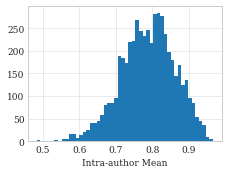

In [144]:

fig = plt.figure(figsize=(HALF_COL_WIDTH, HEIGHT))

plt.hist(intra_probs_mean[aggr_score > 0.95], bins=50)

plt.xlabel('Intra-author Mean')
plt.grid(True, alpha=0.5)
plt.tight_layout()

plt.show()